In [6]:
import os
import imageio
import cv2
from pygifsicle import optimize
import argparse


def make_gif(root, files, size = (621, 200), fps = 1):
  
    imageio.mimwrite(gifname, images, format = '.gif', fps = fps, duration = 0.4)       
#     optimize(gifname)
    print('Created Gif {}'.format(gifname))    
    

In [12]:

gifname = 'kitti.gif'
make_gif(root, gifname)

Created Gif kitti.gif


In [9]:
import os
import glob
import cv2
import numpy as np
from PIL import Image

def depth2color(img): 
    color = cv2.applyColorMap(cv2.convertScaleAbs(img, alpha=0.0355), cv2.COLORMAP_JET)[:,:,::-1]    
    return color   

def add_mask(depth, validity_mask): 
    MIN_DEPTH = 0.0
    MAX_DEPTH = min(300, np.percentile(depth, 99))
    depth = np.clip(depth, MIN_DEPTH, MAX_DEPTH) 
    depth[ validity_mask== 0] = 0 
    return depth

def fetch_data(imgs, index, dataset = 'diode'):
    if dataset == 'nyu': # nyu
           rgb_path = imgs[index]
           depth_path = rgb_path.replace('rgb_', 'sync_depth_')[:-4]+'.png'
           mask_path = None
        
    elif dataset == 'realsense': # realsense  
        rgb_path = imgs[index]
        depth_path = rgb_path[:-4] + '_depth.npy'
        mask_path = None
    
    elif dataset == 'diode' : # diode
        rgb_path = imgs[index]
        depth_path = rgb_path[:-4] + '_depth.npy'
        mask_path = rgb_path[:-4] + '_depth_mask.npy'
    elif dataset == 'kitti':
        rgb_path = imgs[index]
        depth_path = os.path.join('kitti_choice', 'depth', os.path.basename(rgb_path))
        mask_path = None
    return rgb_path, depth_path, mask_path

def resize(image, depth, size):
    image = cv2.resize(image, size, interpolation = cv2.INTER_NEAREST)
    depth = cv2.resize(depth, size, interpolation = cv2.INTER_NEAREST)
    return image, depth

def load_data(rgb_path, depth_path, mask_path, dataset = 'diode'):
    image = Image.open(rgb_path).convert('RGB')
    image = np.array(image, dtype = np.uint8)
    
    if dataset == 'diode':
        depth_gt = np.load(depth_path).squeeze()
        depth_mask = np.load(mask_path)
        depth_gt = add_mask(depth_gt, depth_mask)
        
    elif dataset == 'realsense':
        depth_gt = (np.load(depth_path) / 1000).astype('float32')
        # depth_gt = depth_gt[45:472, 43:608]
        depth_gt[depth_gt > 10] = 0
        # image = image[45:472, 43:608]
  
    elif dataset == 'nyu':
        depth_gt = Image.open(depth_path)
        depth_gt = np.asarray(depth_gt, dtype = np.float32) / 1000
        # depth_gt = depth_gt[45:472, 43:608]
        # image = image[45:472, 43:608]
    elif dataset == 'kitti':
        depth_gt = Image.open(depth_path)
        depth_gt = np.asarray(depth_gt, dtype = np.float32) / 256
 
    return image, depth_gt

def make_video(img_folder, save_name, fps= 15, size = (420, 320) , suffix = '', dataset = 'diode'):
    #fetch data
    images = [os.path.join(img_folder, img) for img in sorted(os.listdir(img_folder)) if img.endswith((suffix))]
    images.sort(key=os.path.getctime)
    ## nyu
    # images = [img for img in sorted(glob.glob(img_folder + f'**/{suffix}/rgb*', recursive= True))]

    # frame = cv2.imread(os.path.join(img_folder, images[0])) 
    # h, w , c = frame.shape
    
    if dataset == 'kitti':
        out = cv2.VideoWriter(save_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, (size[0], size[1]*2))
    else:
        out = cv2.VideoWriter(save_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, (size[0]*2, size[1]))
        
    for index in range(len(images)):
        rgb_path, depth_path, mask_path = fetch_data(images, index, dataset= dataset)
        image, depth = load_data(rgb_path, depth_path, mask_path, dataset= dataset)
        image, depth = resize(image, depth, size = size)
        color_map = depth2color(depth*1000)
        if dataset == 'kitti':
            concat_img = cv2.vconcat([image, color_map])[...,::-1]
            out.write(concat_img)
        else:
            concat_img = cv2.hconcat([image, color_map])[...,::-1]  
            out.write(concat_img)
    
    out.release()
    print('Finished {}'.format(save_name))

def make_gif(img_folder, save_name, fps = 1 , size = (320, 240), suffix= '', dataset = 'diode'):  
    images = [os.path.join(img_folder, img) for img in sorted(os.listdir(img_folder)) if img.endswith((suffix))]
    images.sort(key=os.path.getctime)
    image_list = []
    for index in range(len(images)):
        rgb_path, depth_path, mask_path = fetch_data(images, index, dataset= dataset)
        image, depth = load_data(rgb_path, depth_path, mask_path, dataset= dataset)
        image, depth = resize(image, depth, size = size)
        if dataset == 'kitti':
            color_map = depth2color(depth*256)
            concat_img = cv2.vconcat([image, color_map]) 
        else:
            color_map = depth2color(depth*1000)
            concat_img = cv2.hconcat([image, color_map])
#         print(concat_img.shape)
        image_list.append(concat_img)
    
    imageio.mimwrite(save_name, image_list, format = '.gif', fps = fps, duration = 0.2)       
#     optimize(gifname)
    print('Created Gif {}'.format(save_name))
    
        
        
def check_video(save_name):
    cap = cv2.VideoCapture(save_name)
    while True:
        ret, frame = cap.read()
        if not ret:
            cv2.destroyAllWindows()
            break
            
        cv2.imshow('Check_Video', frame)
        if cv2.waitKey(30) == 27:
            break
    cv2.destroyAllWindows()
    cap.release()   
    
if __name__ == '__main__':
    
    img_folder = 'diode_indoor_choice/'
    out_path = './'
    dataset = 'diode'
    save_name = os.path.join(out_path, f'{dataset}_new.gif')
#     make_video(img_folder, save_name, fps= 45, size = (640,480), suffix = '.png', dataset = dataset)    
    make_gif(img_folder, save_name, fps= 20, size = (480, 320), suffix = '.png', dataset = dataset)
#     check_video(save_name)
 


Created Gif ./diode_new.gif


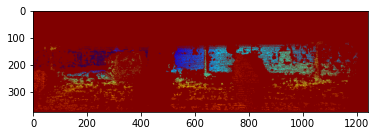

In [38]:
import matplotlib.pyplot as plt
root = 'kitti_choice/depth/0000000005.png'
depth = cv2.imread(root, cv2.IMREAD_ANYDEPTH).astype('float32')
color_map = depth2color(depth)[...,::-1]
plt.imshow(color_map) ; plt.show()

In [3]:
ls

create_image2gif.ipynb  diode_indoor_choice/  kitti.gif    nyu.gif
diode_choice/           kitti_2.gif           nyu_2.gif    realsense_choice/
diode.gif               kitti_choice/         nyu_choice/  realsense.gif


In [4]:
!pwd

/home/zmh/hdd/Projects/Group-A/Depth_Map/evaluation_depth_map/my_projects/depth_estimation/videos/gif
